<a href="https://colab.research.google.com/github/fdhernandezgutierrez/LUNET_Brain-Tumor/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
import h5py
import os
!pip install tensorflow==2.15    # Funcionó correctamente 2.9.1
!pip install tensorflow-addons==0.17.1
%run models.ipynb
%run SegmentationMetrics.ipynb
%run readImages.ipynb

In [3]:
X_train_, Y_train_ = read_h5_file('data', 'brats2021','train')
X_test_, Y_test_   = read_h5_file('data', 'brats2021','test')
print(np.shape(X_train_))
print(np.shape(X_test_))

(871, 240, 240, 1)
(374, 240, 240, 1)


In [4]:
def scale_fn(x):
    return (0.99 ** (x - 1))

INIT_LR         = 0.0001 #1e-6  0.001
MAX_LR          = 0.8   #1e-4
BATCH_SIZE      = 1#16#64 #16
initial_filter  = 16#32
steps_per_epoch = len(X_train_) // BATCH_SIZE
cyclical_learning_rate = tfa.optimizers.CyclicalLearningRate(initial_learning_rate =INIT_LR,
                                              maximal_learning_rate = MAX_LR,
                                              step_size             = 10*steps_per_epoch,
                                              scale_fn              = scale_fn,
                                              scale_mode            = 'cycle')

SeLU            = tf.keras.activations.selu
ReLU            = tf.keras.layers.ReLU()
initializer     ='HeNormal'
lr = 0.0001
opt             = tf.keras.optimizers.SGD(learning_rate =cyclical_learning_rate, momentum=0.9,
                                          nesterov=True)
SGD_CLR          = tf.keras.optimizers.SGD(learning_rate =cyclical_learning_rate, momentum=0.9,
                                          nesterov=True)
Adam             = tf.keras.optimizers.Adam(learning_rate =0.001)#, momentum=0.9,
Adam_CLR         = tf.keras.optimizers.Adam(learning_rate =cyclical_learning_rate)
#opt             = tf.keras.optimizers.AdamW(learning_rate = cyclical_learning_rate)
inputs          = tf.keras.layers.Input((240, 240, 1))
epochs          = 1# 200#500
# Creando el model

# UNET Base

In [5]:
Model_Base = UNET_BASE(optimizer= Adam, activation_function =ReLU,
             initializer= initializer, inputs= inputs, initial_filter= 64)
Model_Base.train(X_train_, Y_train_, BATCH_SIZE, epochs)
metrics_Base = Model_Base.testing(X_test_, Y_test_, 0.5)
model = Model_Base.get_model()
FLOPS = get_flops(model, (1, 240, 240, 1))
print(metrics_Base)
print(FLOPS)

  6/696 [..............................] - ETA: 58s - loss: 0.8593 - accuracy: 0.8616

696/696 [==============================] - ETA: 0s - loss: 0.6630 - accuracy: 0.9563
Epoch 1: val_loss improved from -inf to 0.65302, saving model to test
696/696 [==============================] - 87s 98ms/step - loss: 0.6630 - accuracy: 0.9563 - val_loss: 0.6530 - val_accuracy: 0.9577
semantic loss functions initialized
1/1 [==============================] - 0s 19ms/step


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


[0.0, 0.001081972, 0.0, 1.0]


84578515200


# UNET(BN)

696/696 [==============================] - ETA: 0s - loss: 0.2105 - accuracy: 0.9493
Epoch 1: val_loss improved from inf to 0.19034, saving model to test
696/696 [==============================] - 35s 23ms/step - loss: 0.2105 - accuracy: 0.9493 - val_loss: 0.1903 - val_accuracy: 0.9349
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


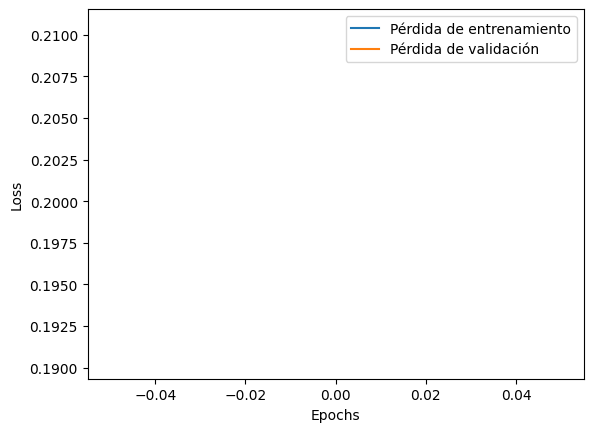

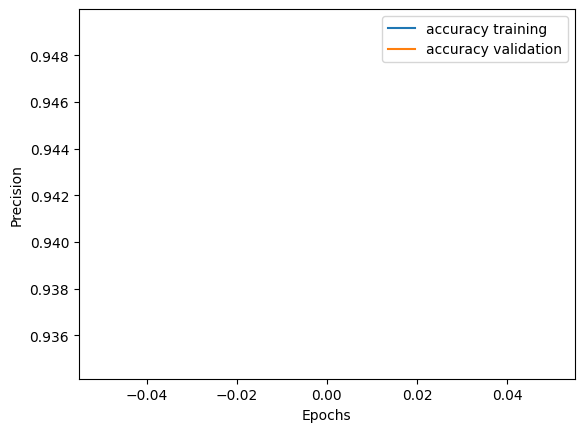

semantic loss functions initialized
1/1 [==============================] - 0s 31ms/step


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


[0.313934, 0.43004248, 0.6461677937670349, 0.9456271019211427]
5307897600


In [5]:
Model_BN = UNET(optimizer=Adam, activation_function =ReLU, initializer= initializer, inputs= inputs, initial_filter= initial_filter)
Model_BN.train(X_train_, Y_train_, epochs= epochs, btz = BATCH_SIZE)
metrics = Model_BN.testing(X_test_, Y_test_)
model   = Model_BN.get_model()
FLOPS   = get_flops(model, (1, 240, 240, 1))

print(metrics)
print(FLOPS)

# UNET (BN & CLR)

696/696 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.9473
Epoch 1: val_loss improved from inf to 0.25299, saving model to test
696/696 [==============================] - 28s 23ms/step - loss: 0.1543 - accuracy: 0.9473 - val_loss: 0.2530 - val_accuracy: 0.9577
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


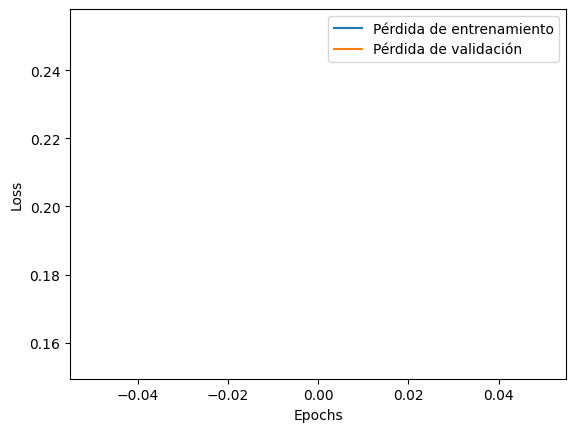

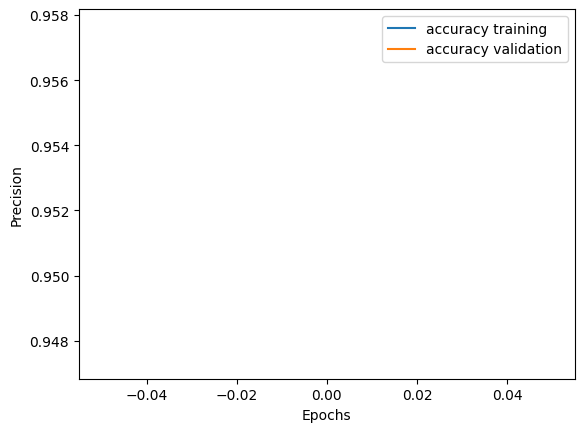

semantic loss functions initialized
1/1 [==============================] - 0s 29ms/step
[1.2778002e-06, 0.0010845262, 1.277800174405111e-06, 1.0]


In [6]:
Model_BN_CLR = UNET(optimizer=Adam_CLR, activation_function =ReLU,
             initializer= initializer, inputs= inputs, initial_filter= initial_filter)
Model_BN_CLR.train(X_train_, Y_train_, BATCH_SIZE, epochs, show_history=True)
metrics = Model_BN_CLR.testing(X_test_, Y_test_)
FLOPS   = get_flops(Model_BN_CLR.get_model(), (1, 240, 240,1))
print(metrics)
print(FLOPS)

# UNET (BN & CLR & SGD)

In [33]:
Model_BN_CLR_SGD = UNET(optimizer=SGD_CLR, activation_function =ReLU, initializer= initializer, inputs= inputs, initial_filter= initial_filter)

Model_BN_CLR_SGD.train(X_train_, Y_train_, BATCH_SIZE, epochs)
metrics = Model_BN_CLR_SGD.testing(X_test_, Y_test_)
model = Model_BN_CLR_SGD.get_model()
FLOPS   = get_flops(model, (1, 240, 240))
print(metrics)

StagingError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 225, in _update_step_xla  *
        return self._update_step(gradient, variable)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 233, in _update_step  **
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable c1_1/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.SGD.'


# UNET (BN & CLR & SGD & SeLU)

In [32]:
Model_BN_CLR_SGD_SeLU = UNET(optimizer=SGD_CLR, activation_function =SeLU, initializer= initializer, inputs= inputs, initial_filter= initial_filter)
Model_BN_CLR_SGD_SeLU.train(X_train_, Y_train_, BATCH_SIZE, epochs)
metrics = Model_BN_CLR_SGD_SeLU.testing(X_test_ , Y_test_)
HD      = HaussDorff_Distance(Model_BN_CLR_SGD_SeLU.get_model(), X_test_, Y_test_)
FLOPS   = get_flops(Model_BN_CLR_SGD_SeLU.get_model(), (1, 240, 240,1))

print(metrics)
print(HD)
pritn(FLOPS)

StagingError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 225, in _update_step_xla  *
        return self._update_step(gradient, variable)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 233, in _update_step  **
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable c1_1/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.SGD.'


# UNET ++

In [26]:


Model_UNETPP  = UNETPP()
Model_UNETPP.train(X_train= X_train_,Y_train= Y_train_,batch_size= BATCH_SIZE,  epochs = epochs)
metrics = Model_UNETPP.testing(X_test_, Y_test_)
HD      = HaussDorff_Distance(Model_UNETPP.get_model(), X_test_, Y_test_)
FLOPS   = get_flops(Model_UNETPP.get_model(), (1, 240, 240, 1))

print(metrics)
print(HD)
print(FLOPS)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 240, 240, 1)]        0         []                            
                                                                                                  
 conv2d_104 (Conv2D)         (None, 240, 240, 64)         640       ['input_9[0][0]']             
                                                                                                  
 batch_normalization_152 (B  (None, 240, 240, 64)         256       ['conv2d_104[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 re_lu_73 (ReLU)             (None, 240, 240, 64)         0         ['batch_normalization_15